# Projet M1 ISI: Apprentissage auto-supervisé de représentations audio pour l'exploration de paysages sonores

In [ ]:
# On télécharge le modèle de WavTokenizer que nous allons utiliser
!wget https://huggingface.co/novateur/WavTokenizer-large-speech-75token/resolve/main/wavtokenizer_large_speech_320_v2.ckpt -O /content/WavTokenizer/large_model.ckpt
# Possibilité de telecharger un autre modele => cf. wavtokenizer_large_unify_600_24k? (config 40tok/s)

In [ ]:
# On télécharge le dossier comprésé contenant les tokens calculés au préalable
%cd /content/
import os
!wget https://raw.githubusercontent.com/GhilesREDJDAL/Projet-M1-ISI-SSL-paysages-sonores/main/esc50_tokens_WavTokenizer.zip
zip_path = "/content/esc50_tokens_WavTokenizer.zip"

# Extraction des tokens (si téléchargés)
if not os.path.exists(zip_path):
    print("Le fichier n'existe pas.")
else:
    print("Le fichier existe.")
    !unzip {zip_path} -d /content

In [17]:
%cd /content
# On télécharge le bibliothèque WavTokenizer (on clone le repo git)
!git clone https://github.com/jishengpeng/WavTokenizer.git
%cd WavTokenizer

# On importe le constructeur et le convertisseur audio (WavTokenizer prend des fichiers audios de Fs=24kHz)
from decoder.pretrained import WavTokenizer
from encoder.utils import convert_audio

%cd /content

/content
fatal: destination path 'WavTokenizer' already exists and is not an empty directory.
/content/WavTokenizer
/content


In [18]:
# Import des bibliothèques utilisées
import torch
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm # Pour la barre de progression (inference et parcours des fichiers)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN

In [19]:
# On télécharge le dataset sur lequel nous effectuons nos tests
# Autres datasets à tester: FSC-22, EFSC-24 (plus orientés fôrets, à trouver)
%cd /content
!git clone https://github.com/karolpiczak/ESC-50.git
%cd ESC-50
%cd /content/
audio_dir = "/content/ESC-50/audio"
meta_csv = "/content/ESC-50/meta/esc50.csv"

metadata = pd.read_csv(meta_csv)

/content
Cloning into 'ESC-50'...
remote: Enumerating objects: 4199, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 4199 (delta 62), reused 34 (delta 34), pack-reused 4130 (from 1)
Receiving objects: 100% (4199/4199), 878.77 MiB | 25.52 MiB/s, done.
Resolving deltas: 100% (292/292), done.
Updating files: 100% (2011/2011), done.
/content/ESC-50
/content


In [20]:
# Détermine le périphérique à utiliser (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chemin vers le fichier de configuration du modèle WavTokenizer
config_path = "/content/WavTokenizer/configs/wavtokenizer_smalldata_frame75_3s_nq1_code4096_dim512_kmeans200_attn.yaml"
# Chemin vers le fichier du modèle pré-entraîné WavTokenizer
model_path = "/content/WavTokenizer/large_model.ckpt"

# Charge le modèle WavTokenizer:
wavtokenizer = WavTokenizer.from_pretrained0802(config_path, model_path)

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [ ]:
# Inference: pas besoin de refaire, les tokens sont fournit dans le fichier .zip
"""
# Répertoire de sortie pour les tokens
output_dir_tok = "/content/esc50_tokens_WavTokenizer"
# Répertoire de sortie pour les features (commenté, car non utilisé)
#output_dir_features = "/content/esc50_features_WavTokenizer"

# Crée les répertoires de sortie s'ils n'existent pas déjà
# os.makedirs(output_dir_features, exist_ok=True) # Commenté car output_dir_features n'est pas utilisé
os.makedirs(output_dir_tok, exist_ok=True)

# Déplace le modèle WavTokenizer sur le périphérique sélectionné (GPU ou CPU)
wavtokenizer = wavtokenizer.to(device)

# On boucle sur chaque fichier audio dans le répertoire d'audio
for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
    # Extrait le nom du fichier audio et construit le chemin complet
    filename = row["filename"]
    path = os.path.join(audio_dir, filename)

    # Traitement du fichier audio
    try:
        # Charge le waveform et le taux d'échantillonnage
        waveform, sr = torchaudio.load(path)
        # Convertit le waveform au format requis par WavTokenizer (24kHz, mono)
        waveform = convert_audio(waveform, sr, 24000, 1).to(device)
        bandwidth_id = torch.tensor([0]).to(device)

        # Encode le waveform pour obtenir les features et les codes discrets
        features, discrete_code = wavtokenizer.encode_infer(waveform, bandwidth_id=bandwidth_id)

        # Construit les chemins de sortie pour les tokens et les features
        token_path = os.path.join(output_dir_tok, filename.replace(".wav", ".pt"))
        # feature_path = os.path.join(output_dir_features, filename.replace(".wav", ".pt")) # Commenté car non utilisé

        # Sauvegarde les codes discrets (tokens)
        torch.save(discrete_code.cpu(), token_path)
        # Sauvegarde les features (commenté, car non utilisé)
        #torch.save(features.cpu(), feature_path) # Pas besoin de sauvegarder les features (utilisation de code_to_features)

    # Gère les exceptions qui peuvent survenir lors du traitement d'un fichier audio
    except Exception as e:
        # Affiche un message d'erreur si un problème survient
        print(f"Error with {filename}: {e}")
"""

WavTokenizer attribue à chaque fichier audio une séquence de tokens (40 ou 75 tokens par secondes), où chaque token représente une ligne dans un codebook, cette ligne correspondant à une représentation audio pré-apprise lors de l'entrainement (feature).
Les features extraites directement par WavTokenizer sont identiques à celles obtenues en utilisant la fonction codes_to_features sur les codes discrets (tokens). C'est pourquoi les features brutes n'ont pas été utilisées ou enregistrées séparément dans ce notebook, car les vecteurs du codebook dérivés des tokens fournissent les mêmes informations pour l'analyse.

In [40]:
# Rrépertoire contenant les tokens enregistrés
tokens_dir = '/content/esc50_tokens_WavTokenizer'
# Répertoire contenant les features enregistrées (commenté)
#features_dir = '/content/esc50_features_WavTokenizer'

# Charge les métadonnées du dataset ESC-50
meta_df = pd.read_csv('/content/ESC-50/meta/esc50.csv')
# Remplace l'extension '.wav' par '.pt' dans la colonne 'filename' pour correspondre aux fichiers de tokens
meta_df['filename'] = meta_df['filename'].str.replace('.wav', '.pt')

# Initialise des listes vides pour stocker différentes informations sur les tokens et features (selon les cas)
all_tokens = []
file_to_tokens = {}
tok_seq = []
all_tok_per_file = []
max_tokens = []
mean_tokens = []
feat_vectors_all = []
codebook_vectors_all = []
cb_vect_all = []

# Boucle sur chaque fichier dans le répertoire des tokens
for fname in tqdm(os.listdir(tokens_dir)):
    # Ignore les fichiers qui ne se terminent pas par '.pt'
    if not fname.endswith('.pt'):
        continue
    # Construit le chemin complet du fichier de tokens
    tok_path = os.path.join(tokens_dir, fname)
    # Charge les tokens à partir du fichier
    tokens = torch.load(tok_path)

    """
    # Charge les features à partir du fichier
    #feat_path = os.path.join(features_dir, fname)
    #features = torch.load(feat_path)

    # Reforme et transpose les features
    #features = features.squeeze(0).transpose(0, 1)
    """

    # Convertit les codes discrets (tokens) en vecteurs de features du codebook
    decoded_feats = wavtokenizer.codes_to_features(tokens)
    # Reforme et transpose les vecteurs de features décodés
    decoded_feats = decoded_feats.squeeze(0).transpose(0, 1)

    # Ajoute les vecteurs de features décodés (convertis en NumPy) à la liste temporaire
    cb_vect_all.append(decoded_feats.numpy())
    # Ajoute les vecteurs de features originaux
    #feat_vectors_all.append(features.numpy())
    # Ajoute la séquence de tokens (aplatie) à la liste
    tok_seq.append(tokens.squeeze())
    """
    # Calcule et ajoute le maximum de tokens
    max_tokens.append([tokens.max()])
    # Calcule et ajoute la moyenne des tokens
    mean_tokens.append([torch.mean(tokens.float()).to(torch.int64)])

    # Ajoute chaque token individuel à la liste
    for tok in tokens:
      all_tokens.append([tok.numpy()])
    # Ajoute le tableau NumPy de tokens par fichier à la liste
    all_tok_per_file.append(tokens.numpy())
    """
# Concatène verticalement les vecteurs de features originaux en un seul tableau NumPy
#feat_vectors_all = np.vstack(feat_vectors_all)
# Concatène verticalement les vecteurs de features décodés (du codebook) en un seul tableau NumPy
codebook_vectors_all = np.vstack(cb_vect_all)
# Concatène verticalement les séquences de tokens
tok_seq = np.vstack(tok_seq)

100%|██████████| 2000/2000 [00:12<00:00, 164.64it/s]


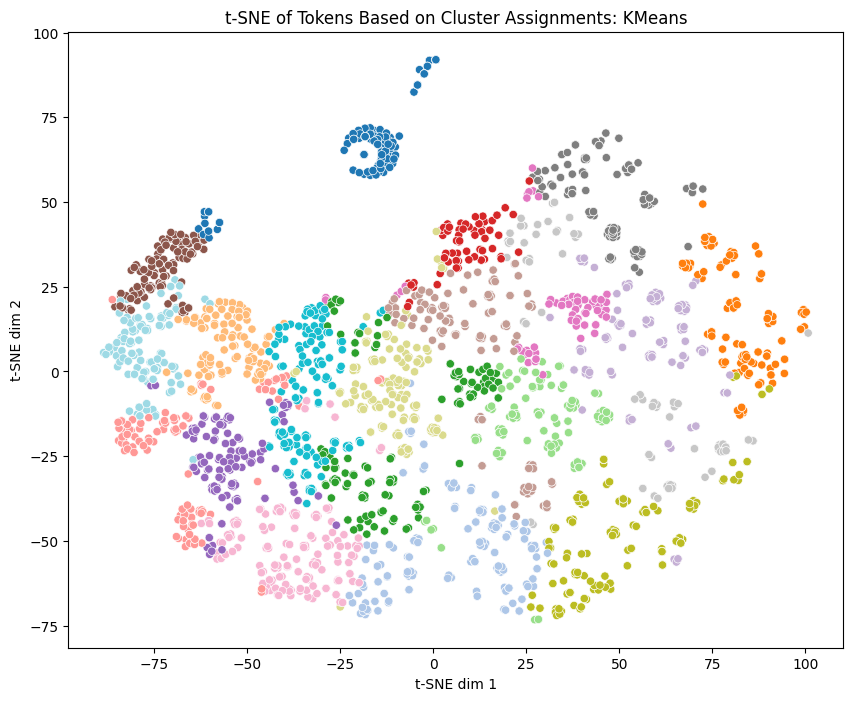

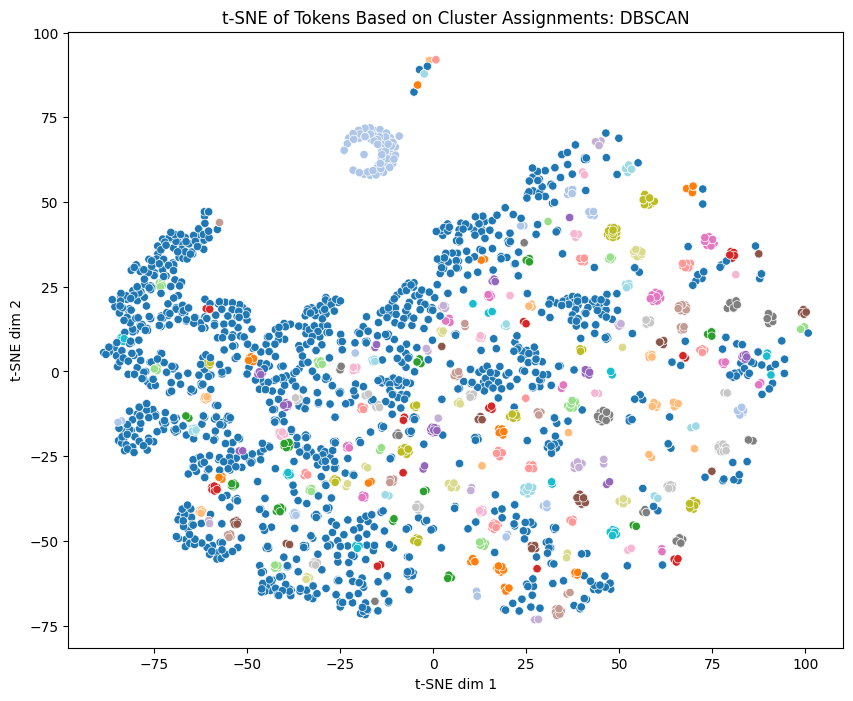

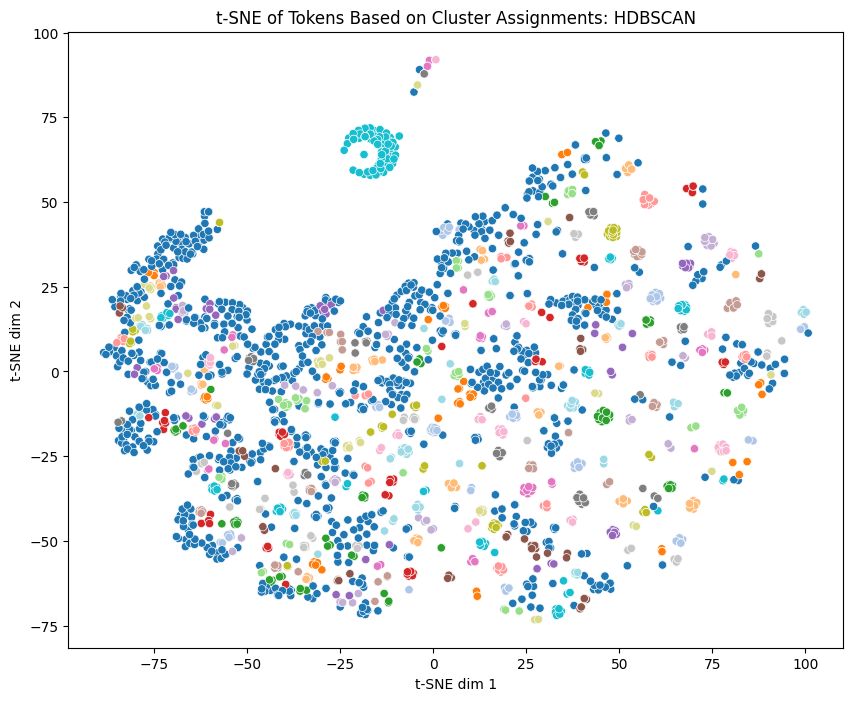

In [33]:
# Nombre de clusters pour KMeans
n_clusters = 20
# Initialise et entraîne un modèle KMeans sur les vecteurs du codebook
kmeans_cb = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_cb.fit(codebook_vectors_all[:375*10,:])

# Initialise et entraîne un modèle DBSCAN sur les vecteurs du codebook
dbscan_cb = DBSCAN(eps=0.5, min_samples=5)
dbscan_cb.fit(codebook_vectors_all[:375*10,:])

# Initialise et entraîne un modèle HDBSCAN sur les vecteurs du codebook
hdbscan_cb = HDBSCAN(min_cluster_size=5)
hdbscan_cb.fit(codebook_vectors_all[:375*10,:])

# Applique t-SNE sur les vecteurs du codebook et obtient les résultats pour chaque algorithme de clustering
resh_tsne_kmeans_cb = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(codebook_vectors_all[:375*10,:])
resh_tsne_dbscan_cb = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(codebook_vectors_all[:375*10,:])
resh_tsne_hdbscan_cb = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(codebook_vectors_all[:375*10,:])

# Crée et affiche un scatter plot des résultats t-SNE colorés par les clusters KMeans
plt.figure(figsize=(10, 8))
sns.scatterplot(x=resh_tsne_kmeans_cb[:, 0], y=resh_tsne_kmeans_cb[:, 1], hue= kmeans_cb.labels_, palette='tab20', legend=False)
plt.title("t-SNE of Tokens Based on Cluster Assignments: KMeans")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.show()

# Crée et affiche un scatter plot des résultats t-SNE colorés par les clusters DBSCAN
plt.figure(figsize=(10, 8))
sns.scatterplot(x=resh_tsne_dbscan_cb[:, 0], y=resh_tsne_dbscan_cb[:, 1], hue= dbscan_cb.labels_, palette='tab20', legend=False)
plt.title("t-SNE of Tokens Based on Cluster Assignments: DBSCAN")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.show()

# Crée et affiche un scatter plot des résultats t-SNE colorés par les clusters HDBSCAN
plt.figure(figsize=(10, 8))
sns.scatterplot(x=resh_tsne_hdbscan_cb[:, 0], y=resh_tsne_hdbscan_cb[:, 1], hue= hdbscan_cb.labels_, palette='tab20', legend=False)
plt.title("t-SNE of Tokens Based on Cluster Assignments: HDBSCAN")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.show()

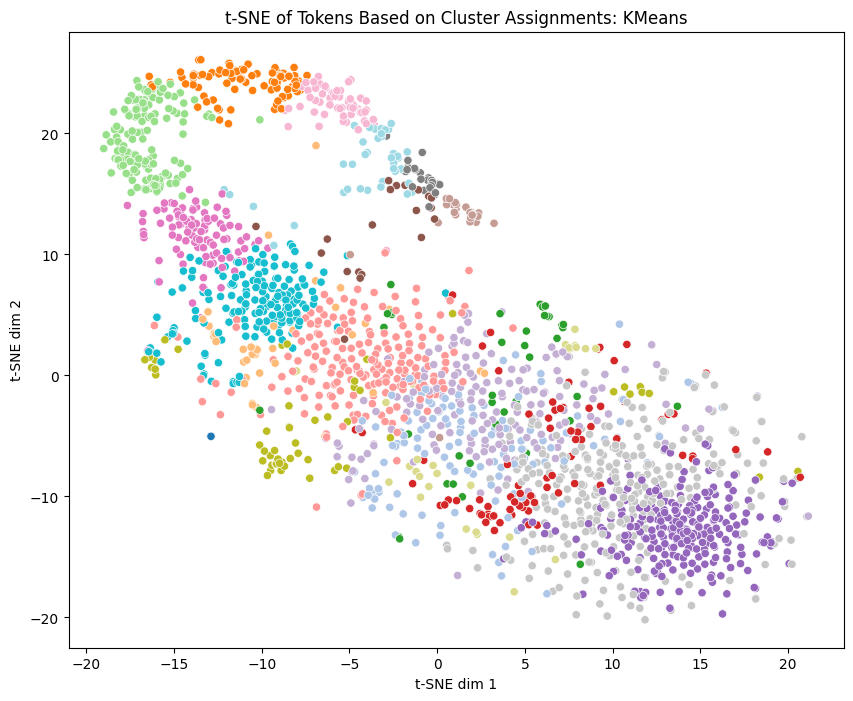

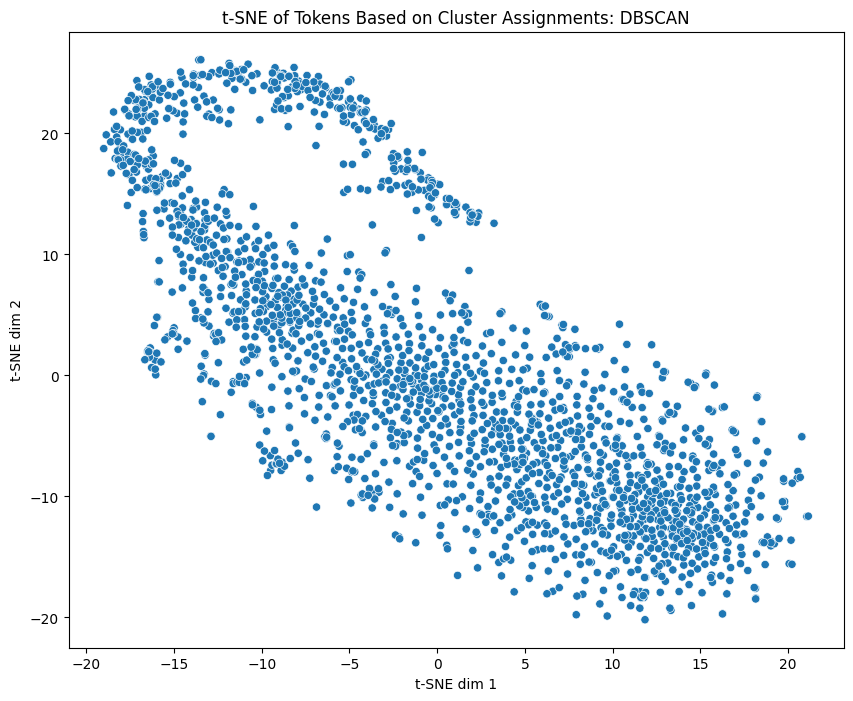

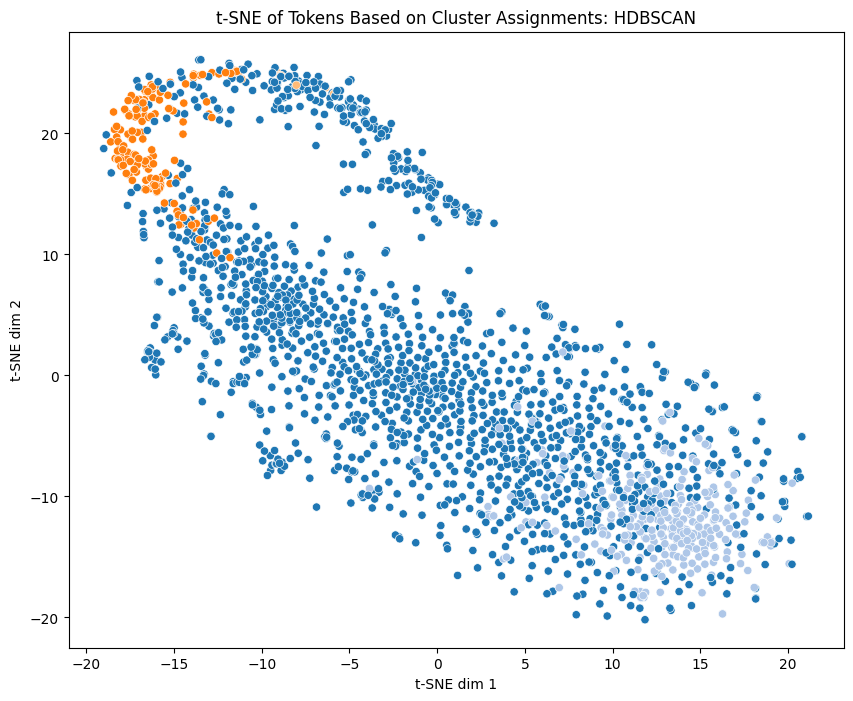

In [35]:
# Nombre de clusters
n_clusters = 20
# Applique KMeans sur les séquences de tokens
kmeans_files = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_files.fit(tok_seq)

# Applique DBSCAN sur les séquences de tokens
dbscan_files = DBSCAN(eps=0.5, min_samples=5)
dbscan_files.fit(tok_seq)

# Applique HDBSCAN sur les séquences de tokens
hdbscan_files = HDBSCAN(min_cluster_size=5)
hdbscan_files.fit(tok_seq)

# Applique t-SNE sur les séquences de tokens pour chaque algorithme de clustering
resh_tsne_kmeans_files = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(tok_seq)
resh_tsne_dbscan_files = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(tok_seq)
resh_tsne_hdbscan_files = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(tok_seq)

# Affiche le t-SNE des séquences de tokens coloré par les clusters KMeans
plt.figure(figsize=(10, 8))
sns.scatterplot(x=resh_tsne_kmeans_files[:, 0], y=resh_tsne_kmeans_files[:, 1], hue= kmeans_files.labels_, palette='tab20', legend=False)
plt.title("t-SNE of Tokens Based on Cluster Assignments: KMeans")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.show()

# Affiche le t-SNE des séquences de tokens coloré par les clusters DBSCAN
plt.figure(figsize=(10, 8))
sns.scatterplot(x=resh_tsne_dbscan_files[:, 0], y=resh_tsne_dbscan_files[:, 1], hue= dbscan_files.labels_, palette='tab20', legend=False)
plt.title("t-SNE of Tokens Based on Cluster Assignments: DBSCAN")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.show()

# Affiche le t-SNE des séquences de tokens coloré par les clusters HDBSCAN
plt.figure(figsize=(10, 8))
sns.scatterplot(x=resh_tsne_hdbscan_files[:, 0], y=resh_tsne_hdbscan_files[:, 1], hue= hdbscan_files.labels_, palette='tab20', legend=False)
plt.title("t-SNE of Tokens Based on Cluster Assignments: HDBSCAN")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.show()

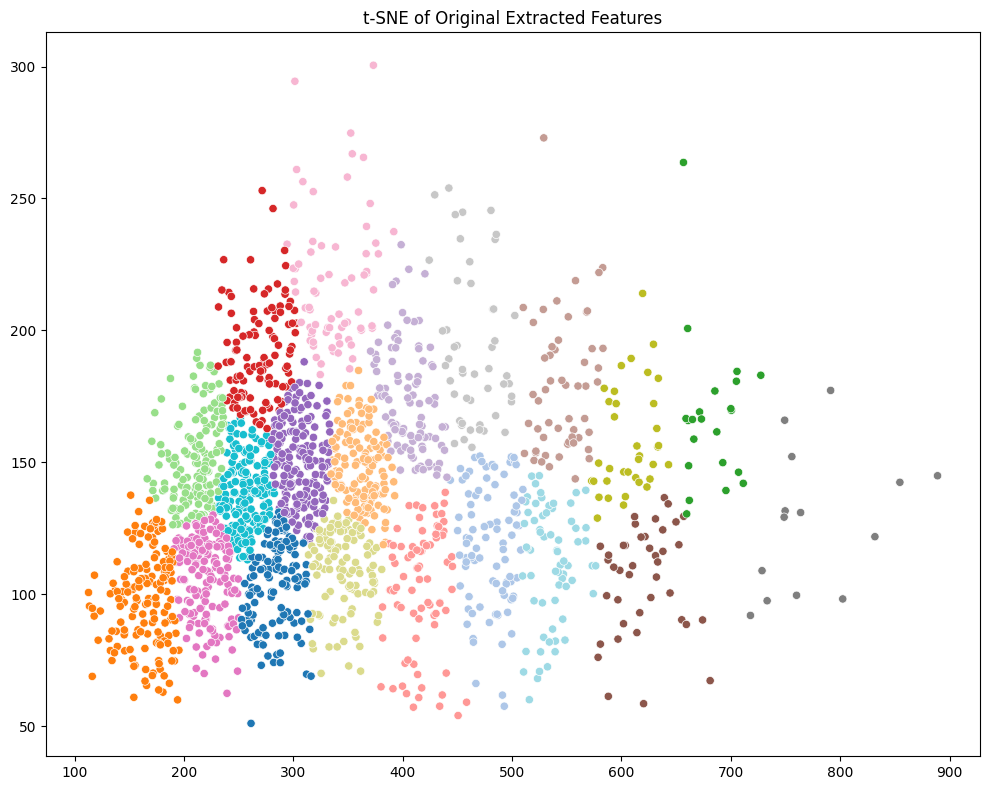

In [39]:
# Initialise une liste pour stocker les valeurs singulières de la PCA
tok_eighs = []
# Boucle sur chaque séquence de vecteurs du codebook par fichier
for seq in cb_vect_all:
  # Initialise un modèle PCA avec 2 composantes
  pca = PCA(n_components=2)
  # Applique la PCA sur la séquence
  pca.fit(seq)
  # Ajoute les valeurs singulières à la liste
  tok_eighs.append(pca.singular_values_)

# Initialise et entraîne un modèle KMeans sur les valeurs singulières
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_pca.fit(tok_eighs)

# Convertit la liste des valeurs singulières en tableau NumPy
tok_eighs_np = np.array(tok_eighs)
# Crée une figure pour le graphique
plt.figure(figsize=(10, 8))
# Crée un scatter plot des valeurs singulières colorées par les clusters KMeans
sns.scatterplot(x=tok_eighs_np[:, 0], y=tok_eighs_np[:, 1], hue= kmeans_pca.labels_, palette='tab20', legend=False)
# Définit le titre du graphique
plt.title("t-SNE of Original Extracted Features")

# Ajuste automatiquement les paramètres du subplot pour que le graphique s'adapte à la figure
plt.tight_layout()
# Affiche le graphique
plt.show()